# %% [markdown]

 # Alternative Clustering Using DBSCAN for the Sessa Empirical Estimator (SEE)

 This section replaces k-means with DBSCAN to cluster sliding-window adherence trajectories.
 We perform the following steps:
 1. Standardize the trajectory data.
 2. Apply DBSCAN with tunable parameters (eps and min_samples).
 3. Evaluate clustering performance using the Adjusted Rand Index (ARI).
 4. Visualize average trajectories per DBSCAN cluster and generate a confusion matrix.

 This approach provides new insights, particularly for identifying non-spherical clusters and handling noise.

In [ ]:
# %% [code]

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')
logger = logging.getLogger(__name__)

# For reproducibility
np.random.seed(123)

# %% [markdown]

 ## Function: DBSCAN Clustering on Trajectory Data

 This function standardizes the trajectory data, applies DBSCAN,
 and returns cluster labels. Noise points are labeled as -1.

In [ ]:
# %% [code]

def perform_dbscan_clustering(trajectory_df, eps=0.8, min_samples=3):
    """
    Performs DBSCAN clustering on the provided trajectory data.
    
    Parameters:
    -----------
    trajectory_df : pandas.DataFrame
        DataFrame where each row represents an individual's adherence trajectory.
    eps : float, default=0.8
        Maximum distance between two samples for them to be considered as in the same neighborhood.
    min_samples : int, default=3
        Minimum number of samples in a neighborhood for a point to be considered as a core point.
    
    Returns:
    --------
    dbscan_labels : numpy.array
        Cluster labels assigned by DBSCAN (noise points are labeled as -1).
    """
    try:
        scaler = StandardScaler()
        traj_std = scaler.fit_transform(trajectory_df)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(traj_std)
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        logger.info(f"DBSCAN identified {n_clusters} clusters (with noise labeled as -1).")
        return dbscan_labels
    except Exception as e:
        logger.error(f"Error in perform_dbscan_clustering: {e}")
        raise

# %% [markdown]

 ## Apply DBSCAN Clustering on Precomputed Trajectories

 We assume that trajectory data has already been computed.
 For demonstration, we use `traj_df` from our previous pipeline (computed with non-overlapping windows of 90 days).

 If not available, the trajectory DataFrame can be computed as shown earlier:

     traj_df = compute_all_trajectories(daily_adherence_dict, window_length=90, step=90)


In [ ]:
# %% [code]

# For demonstration, we assume traj_df exists from a previous simulation.
# We'll simulate a minimal version of traj_df using our earlier simulation code.

# --- Begin: Simulate Trajectories from Refill Histories (for context) ---

# Simulation parameters (as defined earlier)
n_individuals = 100
observation_period = 720  # days
window_length = 90        # non-overlapping windows => 8 windows

# Define group proportions for simulation
group_labels = []
group_labels += [1] * 10    # Group 1: High adherence
group_labels += [2] * 20    # Group 2: Erratic adherence
group_labels += [3] * 20    # Group 3: Gradual decline
group_labels += [4] * 20    # Group 4: Intermittent adherence
group_labels += [5] * 20    # Group 5: Partial drop-off
group_labels += [6] * 10    # Group 6: Non-persistence
group_labels = np.array(group_labels)
np.random.shuffle(group_labels)

def simulate_refill_history(group, observation_period):
    history = [(1, 30)]
    current_day = 1
    while current_day < observation_period:
        if group == 1:
            next_day = current_day + history[-1][1]
            supply = history[-1][1]
        elif group == 2:
            next_day = current_day + history[-1][1] + np.random.randint(-5, 6)
            next_day = max(current_day + 1, next_day)
            supply = np.random.choice([30, 60, 90])
        elif group == 3:
            delay = np.random.randint(0, 15)
            next_day = current_day + history[-1][1] + delay
            supply = np.random.choice([30, 60, 90])
        elif group == 4:
            if len(history) % 2 == 0:
                next_day = current_day + history[-1][1]
            else:
                next_day = current_day + history[-1][1] + np.random.randint(10, 20)
            supply = np.random.choice([30, 60, 90])
        elif group == 5:
            if len(history) < 3:
                next_day = current_day + history[-1][1]
            else:
                next_day = current_day + history[-1][1] + np.random.randint(15, 30)
            supply = np.random.choice([30, 60, 90])
        elif group == 6:
            if len(history) < 2:
                next_day = current_day + history[-1][1]
                supply = np.random.choice([30, 60, 90])
            else:
                break
        else:
            next_day = current_day + history[-1][1]
            supply = np.random.choice([30, 60, 90])
        if next_day > observation_period:
            break
        history.append((next_day, supply))
        current_day = next_day
    return history

simulated_histories = {}
true_groups = {}
for i in range(n_individuals):
    group = group_labels[i]
    true_groups[i] = group
    simulated_histories[i] = simulate_refill_history(group, observation_period)

def compute_lcma2_for_individual(refill_history, observation_period):
    daily_adherence = np.full(observation_period, np.nan)
    for i in range(len(refill_history)):
        start_day, supply = refill_history[i]
        if i < len(refill_history) - 1:
            next_refill_day = refill_history[i+1][0]
            interval = next_refill_day - start_day
            adherence_value = supply / interval
            daily_adherence[start_day-1:next_refill_day-1] = adherence_value
        else:
            end_day = min(start_day + supply, observation_period + 1)
            interval = end_day - start_day
            adherence_value = supply / interval if interval > 0 else 0
            daily_adherence[start_day-1:end_day-1] = adherence_value
    daily_adherence = np.nan_to_num(daily_adherence, nan=0.0)
    return daily_adherence

daily_adherence_dict = {}
for i in range(n_individuals):
    daily_adherence_dict[i] = compute_lcma2_for_individual(simulated_histories[i], observation_period)

def compute_sliding_window_trajectory_overlapping(daily_adherence, window_length, step):
    n_days = len(daily_adherence)
    trajectory = []
    for start in range(0, n_days - window_length + 1, step):
        window = daily_adherence[start:start + window_length]
        window_mean = np.mean(window)
        trajectory.append(window_mean)
    return np.array(trajectory)

def compute_all_trajectories(daily_adherence_dict, window_length, step):
    trajectories = {}
    for i in daily_adherence_dict:
        traj = compute_sliding_window_trajectory_overlapping(daily_adherence_dict[i], window_length, step)
        trajectories[i] = traj
    return pd.DataFrame(trajectories).T  # rows: individuals

# Compute trajectories with non-overlapping windows (step = window_length)
traj_df = compute_all_trajectories(daily_adherence_dict, window_length=90, step=90)
# --- End: Simulation of Trajectories ---

# Apply DBSCAN on the computed trajectories
dbscan_labels = perform_dbscan_clustering(traj_df, eps=0.8, min_samples=3)

# Compute ARI comparing DBSCAN clusters to true groups
true_labels = np.array([true_groups[i] for i in range(n_individuals)])
ari_dbscan = adjusted_rand_score(true_labels, dbscan_labels)
logger.info(f"Adjusted Rand Index (ARI) for DBSCAN clustering: {ari_dbscan:.4f}")

2025-02-25 18:39:29,597 INFO:DBSCAN identified 5 clusters (with noise labeled as -1).
2025-02-25 18:39:29,599 INFO:Adjusted Rand Index (ARI) for DBSCAN clustering: 0.5122
2025-02-25 18:39:29,599 INFO:Adjusted Rand Index (ARI) for DBSCAN clustering: 0.5122


# %% [markdown]

 ## Visualize Average Trajectories for DBSCAN Clusters

 We now compute the average trajectory for each DBSCAN cluster (excluding noise) and plot them.

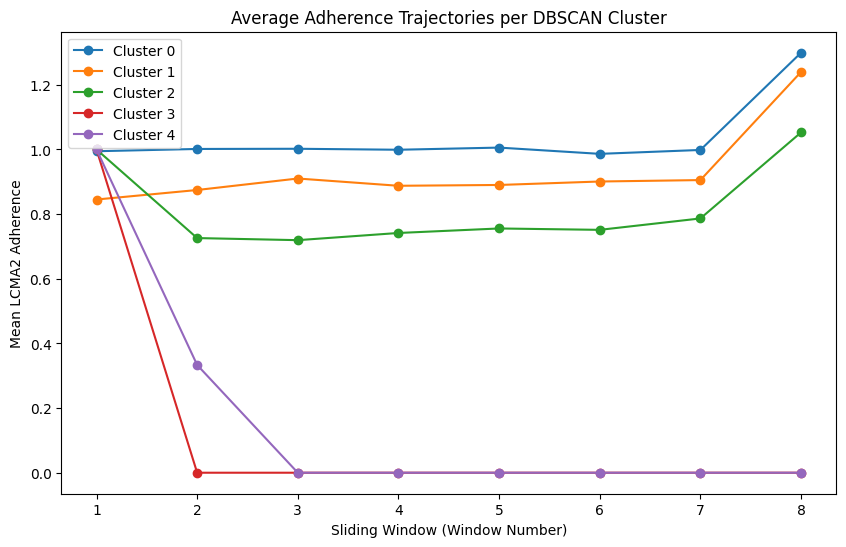

In [ ]:
# %% [code]

traj_df['DBSCAN_cluster'] = dbscan_labels
# Exclude noise points (if any)
valid_clusters = [c for c in set(dbscan_labels) if c != -1]
if valid_clusters:
    cluster_means_dbscan = traj_df[traj_df['DBSCAN_cluster'] != -1].groupby('DBSCAN_cluster').mean()
    plt.figure(figsize=(10, 6))
    for cluster in valid_clusters:
        plt.plot(range(1, cluster_means_dbscan.shape[1] + 1),
                 cluster_means_dbscan.loc[cluster],
                 marker='o', label=f'Cluster {cluster}')
    plt.xlabel('Sliding Window (Window Number)')
    plt.ylabel('Mean LCMA2 Adherence')
    plt.title('Average Adherence Trajectories per DBSCAN Cluster')
    plt.legend()
    plt.show()
else:
    logger.info("No valid clusters found (all points classified as noise).")

# %% [markdown]

 ## Visualize Confusion Matrix for DBSCAN Clusters

 We create a confusion matrix comparing true group labels to the DBSCAN cluster labels.

2025-02-25 18:39:29,853 INFO:Confusion Matrix for DBSCAN Clusters:
DBSCAN Cluster  -1   0   1   2   3   4
True Group                            
1                0  10   0   0   0   0
2                1  19   0   0   0   0
3                2   0  18   0   0   0
4                2   0  18   0   0   0
5               10   0   0  10   0   0
6                1   0   0   0   6   3


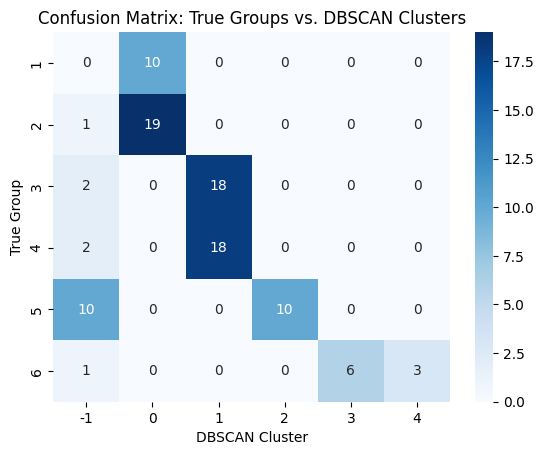

In [ ]:
# %% [code]

dbscan_confusion = pd.crosstab(pd.Series(true_labels, name="True Group"),
                               pd.Series(dbscan_labels, name="DBSCAN Cluster"))
logger.info("Confusion Matrix for DBSCAN Clusters:\n{}".format(dbscan_confusion))
sns.heatmap(dbscan_confusion, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: True Groups vs. DBSCAN Clusters")
plt.show()

# %% [markdown]

 ## Discussion

 - **Performance (ARI):**
   The ARI value (logged above) indicates the similarity between the DBSCAN clusters and the true simulated groups.

 - **Insights from Average Trajectories:**
   The average trajectories for each DBSCAN cluster reveal distinct adherence patterns. Noise points (if present) are automatically identified and excluded.

 - **Advantages of DBSCAN:**
   DBSCAN does not require pre-specification of the number of clusters and can detect non-spherical cluster shapes and noise, offering a complementary perspective to k-means.

 - **Parameter Sensitivity:**
   The performance of DBSCAN is sensitive to the eps and min_samples parameters; further automated tuning (e.g., grid search) could refine these choices.

 **Conclusion:**
 Substituting k-means with DBSCAN provides a robust alternative for clustering longitudinal adherence trajectories. The insights obtained (via ARI, average trajectory plots, and confusion matrices) can help guide parameter optimization and further analysis of adherence patterns in real-world data.